Isotropic Total Variation (ADMM)
================================

This example compares denoising via isotropic and anisotropic total
variation (TV) regularization. It solves the denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is either the isotropic or anisotropic TV regularizer.
In SCICO, switching between these two regularizers is a one-line
change: replacing an
[L1Norm](../_autosummary/scico.functional.rst#scico.functional.L1Norm)
with a
[L21Norm](../_autosummary/scico.functional.rst#scico.functional.L21Norm).
Note that the isotropic version exhibits fewer block-like artifacts on
edges that are not vertical or horizontal.

In [1]:
import jax

from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size
phantom = SiemensStar(16)
x_gt = snp.pad(discrete_phantom(phantom, 240), 8)
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 0.75  # noise standard deviation
noise, key = scico.random.randn(x_gt.shape, seed=0)
y = x_gt + σ * noise

Denoise with isotropic total variation

In [4]:
reg_weight_iso = 1.4e0
f = loss.SquaredL2Loss(y=y)
g_iso = reg_weight_iso * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 20}),
    verbose=True,
)

print(f"Solving on {device_info()}\n")
solver.solve()
x_iso = solver.x

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.29e+00  1.082e+05    3.575e+01  7.402e+01
   1  3.10e+00  9.925e+04    2.837e+00  7.016e+01
   2  3.14e+00  8.971e+04    2.821e+00  6.792e+01


   3  3.18e+00  8.082e+04    3.201e+00  6.555e+01
   4  3.31e+00  7.264e+04    3.592e+00  6.301e+01
   5  3.35e+00  6.515e+04    3.954e+00  6.029e+01


   6  3.39e+00  5.837e+04    4.319e+00  5.738e+01
   7  3.43e+00  5.230e+04    4.623e+00  5.429e+01
   8  3.47e+00  4.692e+04    4.917e+00  5.101e+01
   9  3.51e+00  4.222e+04    5.037e+00  4.767e+01
  10  3.54e+00  3.817e+04    5.139e+00  4.425e+01
  11  3.58e+00  3.471e+04    5.097e+00  4.087e+01


  12  3.62e+00  3.179e+04    5.056e+00  3.741e+01
  13  3.66e+00  2.940e+04    5.062e+00  3.393e+01
  14  3.70e+00  2.745e+04    4.860e+00  3.058e+01
  15  3.74e+00  2.589e+04    4.653e+00  2.730e+01
  16  3.78e+00  2.467e+04    4.397e+00  2.423e+01
  17  3.82e+00  2.373e+04    4.142e+00  2.126e+01


  18  3.86e+00  2.301e+04    3.784e+00  1.855e+01
  19  3.90e+00  2.247e+04    3.391e+00  1.612e+01
  20  3.94e+00  2.207e+04    3.057e+00  1.395e+01
  21  3.98e+00  2.178e+04    2.754e+00  1.194e+01
  22  4.03e+00  2.157e+04    2.440e+00  1.019e+01


  23  4.06e+00  2.141e+04    2.032e+00  8.820e+00
  24  4.10e+00  2.129e+04    1.804e+00  7.560e+00
  25  4.14e+00  2.121e+04    1.630e+00  6.428e+00
  26  4.17e+00  2.116e+04    1.470e+00  5.386e+00
  27  4.20e+00  2.112e+04    1.204e+00  4.604e+00
  28  4.24e+00  2.109e+04    1.083e+00  3.918e+00


  29  4.28e+00  2.107e+04    9.283e-01  3.335e+00
  30  4.32e+00  2.106e+04    8.045e-01  2.880e+00
  31  4.36e+00  2.104e+04    7.025e-01  2.527e+00
  32  4.40e+00  2.104e+04    6.561e-01  2.163e+00
  33  4.43e+00  2.103e+04    5.971e-01  1.829e+00
  34  4.46e+00  2.103e+04    5.309e-01  1.564e+00


  35  4.49e+00  2.103e+04    4.748e-01  1.306e+00
  36  4.53e+00  2.103e+04    4.705e-01  1.074e+00
  37  4.56e+00  2.103e+04    3.838e-01  9.318e-01
  38  4.59e+00  2.103e+04    3.745e-01  7.845e-01
  39  4.63e+00  2.103e+04    3.513e-01  6.460e-01
  40  4.68e+00  2.103e+04    3.124e-01  5.857e-01


  41  4.72e+00  2.103e+04    2.962e-01  4.911e-01
  42  4.75e+00  2.103e+04    2.772e-01  4.430e-01
  43  4.78e+00  2.103e+04    2.614e-01  3.909e-01
  44  4.81e+00  2.103e+04    2.508e-01  3.550e-01
  45  4.84e+00  2.103e+04    2.400e-01  3.310e-01
  46  4.87e+00  2.103e+04    2.329e-01  2.758e-01
  47  4.91e+00  2.103e+04    2.264e-01  2.392e-01


  48  4.94e+00  2.103e+04    2.138e-01  2.240e-01
  49  4.97e+00  2.103e+04    2.067e-01  2.101e-01
  50  5.00e+00  2.103e+04    2.004e-01  1.971e-01
  51  5.04e+00  2.104e+04    1.945e-01  1.854e-01
  52  5.07e+00  2.104e+04    1.891e-01  1.749e-01
  53  5.10e+00  2.104e+04    1.838e-01  1.657e-01
  54  5.13e+00  2.104e+04    1.788e-01  1.572e-01


  55  5.16e+00  2.104e+04    1.741e-01  1.484e-01
  56  5.19e+00  2.104e+04    1.698e-01  1.399e-01
  57  5.22e+00  2.104e+04    1.658e-01  1.319e-01
  58  5.25e+00  2.104e+04    1.622e-01  1.243e-01
  59  5.28e+00  2.104e+04    1.587e-01  1.176e-01
  60  5.31e+00  2.104e+04    1.553e-01  1.120e-01
  61  5.34e+00  2.104e+04    1.519e-01  1.071e-01


  62  5.37e+00  2.104e+04    1.488e-01  1.022e-01
  63  5.41e+00  2.104e+04    1.459e-01  9.677e-02
  64  5.44e+00  2.104e+04    1.433e-01  9.141e-02
  65  5.47e+00  2.104e+04    1.407e-01  8.687e-02
  66  5.51e+00  2.104e+04    1.380e-01  8.325e-02
  67  5.55e+00  2.104e+04    1.353e-01  8.007e-02


  68  5.58e+00  2.104e+04    1.327e-01  7.718e-02
  69  5.63e+00  2.104e+04    1.303e-01  7.403e-02
  70  5.67e+00  2.104e+04    1.281e-01  7.080e-02
  71  5.71e+00  2.104e+04    1.261e-01  6.775e-02
  72  5.75e+00  2.104e+04    1.241e-01  6.494e-02
  73  5.78e+00  2.104e+04    1.222e-01  6.231e-02


  74  5.81e+00  2.104e+04    1.203e-01  6.002e-02
  75  5.84e+00  2.104e+04    1.184e-01  5.778e-02
  76  5.88e+00  2.104e+04    1.164e-01  5.585e-02
  77  5.91e+00  2.104e+04    1.145e-01  5.384e-02
  78  5.94e+00  2.104e+04    1.126e-01  5.227e-02
  79  5.97e+00  2.104e+04    1.108e-01  5.098e-02
  80  6.00e+00  2.104e+04    1.090e-01  4.966e-02


  81  6.03e+00  2.104e+04    1.072e-01  4.836e-02
  82  6.05e+00  2.104e+04    1.055e-01  4.680e-02
  83  6.08e+00  2.104e+04    1.038e-01  4.517e-02
  84  6.11e+00  2.104e+04    1.022e-01  4.369e-02
  85  6.14e+00  2.104e+04    1.006e-01  4.215e-02
  86  6.17e+00  2.104e+04    9.908e-02  4.063e-02
  87  6.20e+00  2.104e+04    9.760e-02  3.934e-02


  88  6.23e+00  2.105e+04    9.607e-02  3.865e-02
  89  6.26e+00  2.105e+04    9.459e-02  3.789e-02
  90  6.28e+00  2.105e+04    9.322e-02  3.659e-02
  91  6.31e+00  2.105e+04    9.188e-02  3.523e-02
  92  6.34e+00  2.105e+04    9.047e-02  3.438e-02
  93  6.37e+00  2.105e+04    8.903e-02  3.388e-02
  94  6.40e+00  2.105e+04    8.767e-02  3.304e-02
  95  6.42e+00  2.105e+04    8.635e-02  3.226e-02


  96  6.45e+00  2.105e+04    8.502e-02  3.167e-02
  97  6.48e+00  2.105e+04    8.372e-02  3.066e-02
  98  6.51e+00  2.105e+04    8.250e-02  2.956e-02
  99  6.54e+00  2.105e+04    8.126e-02  2.885e-02


Denoise with anisotropic total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelty as the isotropic case.
reg_weight_aniso = 1.2e0
g_aniso = reg_weight_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 20}),
    verbose=True,
)

solver.solve()
x_aniso = solver.x

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  3.61e-01  1.163e+05    4.213e+01  8.515e+01
   1  4.94e-01  1.057e+05    6.408e+00  8.016e+01
   2  5.36e-01  9.386e+04    6.992e+00  7.642e+01
   3  5.78e-01  8.317e+04    7.290e+00  7.257e+01
   4  6.21e-01  7.357e+04    7.305e+00  6.870e+01


   5  6.66e-01  6.500e+04    7.280e+00  6.480e+01
   6  7.10e-01  5.741e+04    7.233e+00  6.085e+01
   7  7.51e-01  5.078e+04    7.289e+00  5.674e+01
   8  7.93e-01  4.504e+04    7.245e+00  5.260e+01
   9  8.29e-01  4.014e+04    7.127e+00  4.844e+01
  10  8.59e-01  3.603e+04    6.954e+00  4.430e+01


  11  8.90e-01  3.263e+04    6.722e+00  4.018e+01
  12  9.22e-01  2.988e+04    6.513e+00  3.608e+01
  13  9.53e-01  2.770e+04    6.217e+00  3.208e+01
  14  9.84e-01  2.601e+04    5.805e+00  2.825e+01
  15  1.02e+00  2.471e+04    5.336e+00  2.472e+01
  16  1.05e+00  2.373e+04    4.774e+00  2.156e+01
  17  1.08e+00  2.300e+04    4.334e+00  1.867e+01


  18  1.11e+00  2.245e+04    3.772e+00  1.618e+01
  19  1.14e+00  2.204e+04    3.319e+00  1.396e+01
  20  1.17e+00  2.176e+04    3.027e+00  1.185e+01
  21  1.21e+00  2.155e+04    2.600e+00  1.015e+01
  22  1.24e+00  2.140e+04    2.217e+00  8.736e+00
  23  1.27e+00  2.128e+04    1.918e+00  7.556e+00
  24  1.30e+00  2.121e+04    1.771e+00  6.371e+00


  25  1.33e+00  2.116e+04    1.499e+00  5.450e+00
  26  1.37e+00  2.112e+04    1.295e+00  4.641e+00
  27  1.40e+00  2.109e+04    1.178e+00  3.907e+00
  28  1.43e+00  2.107e+04    9.873e-01  3.389e+00
  29  1.46e+00  2.105e+04    8.267e-01  3.019e+00
  30  1.50e+00  2.104e+04    7.588e-01  2.619e+00
  31  1.53e+00  2.103e+04    7.051e-01  2.264e+00


  32  1.56e+00  2.103e+04    6.170e-01  1.999e+00
  33  1.59e+00  2.102e+04    5.759e-01  1.709e+00
  34  1.62e+00  2.102e+04    5.557e-01  1.398e+00
  35  1.66e+00  2.102e+04    4.719e-01  1.211e+00
  36  1.69e+00  2.102e+04    4.084e-01  1.103e+00
  37  1.72e+00  2.102e+04    4.202e-01  9.147e-01
  38  1.75e+00  2.102e+04    3.822e-01  7.868e-01


  39  1.79e+00  2.102e+04    3.351e-01  7.173e-01
  40  1.82e+00  2.102e+04    3.083e-01  6.442e-01
  41  1.85e+00  2.102e+04    2.969e-01  5.751e-01
  42  1.88e+00  2.102e+04    2.697e-01  5.407e-01
  43  1.91e+00  2.102e+04    2.552e-01  5.104e-01
  44  1.94e+00  2.102e+04    2.437e-01  4.814e-01
  45  1.97e+00  2.102e+04    2.341e-01  4.425e-01


  46  2.00e+00  2.102e+04    2.347e-01  3.894e-01
  47  2.04e+00  2.102e+04    2.161e-01  3.679e-01
  48  2.07e+00  2.102e+04    2.088e-01  3.437e-01
  49  2.10e+00  2.102e+04    2.003e-01  3.259e-01
  50  2.14e+00  2.102e+04    1.925e-01  3.106e-01
  51  2.17e+00  2.102e+04    1.857e-01  2.959e-01
  52  2.20e+00  2.102e+04    1.803e-01  2.791e-01


  53  2.24e+00  2.102e+04    1.744e-01  2.652e-01
  54  2.27e+00  2.102e+04    1.695e-01  2.520e-01
  55  2.30e+00  2.102e+04    1.652e-01  2.399e-01
  56  2.33e+00  2.102e+04    1.610e-01  2.292e-01
  57  2.36e+00  2.102e+04    1.569e-01  2.198e-01
  58  2.41e+00  2.102e+04    1.530e-01  2.109e-01


  59  2.45e+00  2.102e+04    1.496e-01  2.013e-01
  60  2.49e+00  2.102e+04    1.463e-01  1.925e-01
  61  2.53e+00  2.102e+04    1.430e-01  1.848e-01
  62  2.57e+00  2.102e+04    1.397e-01  1.783e-01
  63  2.62e+00  2.102e+04    1.365e-01  1.721e-01


  64  2.66e+00  2.102e+04    1.335e-01  1.659e-01
  65  2.70e+00  2.102e+04    1.308e-01  1.595e-01
  66  2.74e+00  2.102e+04    1.278e-01  1.538e-01
  67  2.78e+00  2.102e+04    1.248e-01  1.488e-01
  68  2.81e+00  2.102e+04    1.222e-01  1.432e-01
  69  2.84e+00  2.102e+04    1.198e-01  1.372e-01


  70  2.87e+00  2.102e+04    1.174e-01  1.320e-01
  71  2.90e+00  2.102e+04    1.151e-01  1.276e-01
  72  2.95e+00  2.103e+04    1.129e-01  1.236e-01
  73  3.00e+00  2.103e+04    1.106e-01  1.197e-01
  74  3.04e+00  2.103e+04    1.084e-01  1.159e-01


  75  3.08e+00  2.103e+04    1.065e-01  1.117e-01
  76  3.12e+00  2.103e+04    1.046e-01  1.076e-01
  77  3.15e+00  2.103e+04    1.028e-01  1.038e-01
  78  3.18e+00  2.103e+04    1.010e-01  1.003e-01
  79  3.21e+00  2.103e+04    9.930e-02  9.692e-02
  80  3.25e+00  2.103e+04    9.750e-02  9.411e-02
  81  3.28e+00  2.103e+04    9.562e-02  9.173e-02


  82  3.31e+00  2.103e+04    9.391e-02  8.874e-02
  83  3.35e+00  2.103e+04    9.226e-02  8.593e-02
  84  3.38e+00  2.103e+04    9.084e-02  8.300e-02
  85  3.42e+00  2.103e+04    8.957e-02  8.007e-02
  86  3.45e+00  2.103e+04    8.834e-02  7.731e-02
  87  3.48e+00  2.103e+04    8.716e-02  7.455e-02
  88  3.51e+00  2.103e+04    8.589e-02  7.219e-02


  89  3.54e+00  2.103e+04    8.449e-02  7.007e-02
  90  3.58e+00  2.103e+04    8.312e-02  6.824e-02
  91  3.61e+00  2.103e+04    8.171e-02  6.654e-02
  92  3.65e+00  2.103e+04    8.027e-02  6.522e-02
  93  3.68e+00  2.103e+04    7.887e-02  6.380e-02
  94  3.71e+00  2.103e+04    7.755e-02  6.244e-02
  95  3.74e+00  2.103e+04    7.627e-02  6.089e-02


  96  3.77e+00  2.103e+04    7.510e-02  5.928e-02
  97  3.80e+00  2.103e+04    7.397e-02  5.778e-02
  98  3.84e+00  2.103e+04    7.286e-02  5.641e-02
  99  3.86e+00  2.103e+04    7.172e-02  5.519e-02


Compute the data fidelity.

In [6]:
for x, name in zip((x_iso, x_aniso), ("Isotropic", "Anisotropic")):
    df = f(x)
    print(f"Data fidelity for {name} TV was {df:.2e}")

Data fidelity for Isotropic TV was 1.86e+04
Data fidelity for Anisotropic TV was 1.86e+04


Plot results.

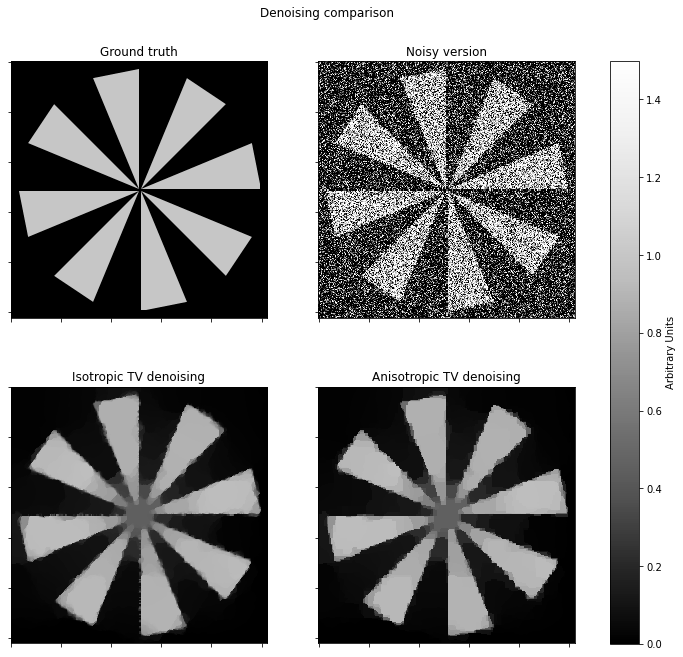

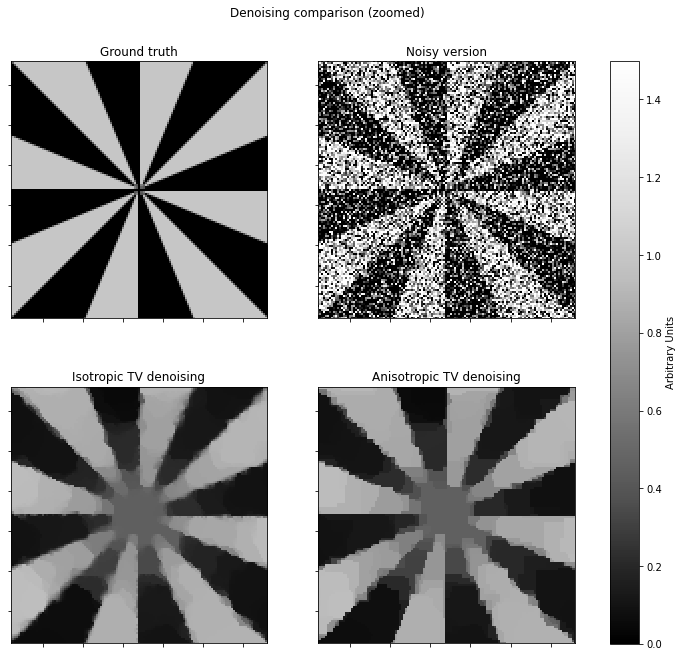

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()